In [2]:
import sys,os
import numpy as np
import pandas as pd
import datetime
import tqdm
import pickle
import h5py
from collections import deque
from math import ceil, sqrt, floor, gamma
from scipy import signal, stats, fftpack 
from sklearn import preprocessing
from PIL import Image
import multiprocessing as mp
import matplotlib.pyplot as plt
# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))
# from dataset import Dataset
# from database import Database
from sample import Sample
from dataset_simulation import DatasetSimulation

class SampleDetector(Sample):
    
    def __init__(self, dataset_location, site, file):
        super().__init__(dataset_location, site, file)
    
    ###################################################
    # SIMULATED WHISTLER
#     def whistler_sim_full_freq(self, decay, size=25, whistler_time=1.2, whistler_freq_len=7, whistler_freq_start=3):
#         time_res, freq_res, freq_len = self.get_time_res(),self.get_freq_res(), len(self.get_freq())
#         data = np.full((size,size),0.001)
#         x = np.linspace(0,1,size)
#         y = np.array([int(np.exp(-decay*_x)*size) for _x in x])
#         y[0] -= 1
#         x,z = np.array(list(range(size))), np.full(size,1e3)
#         for i,j,k in zip(x,y,range(len(z))):
#             data[i,j]= z[k]
#         data = data.T.astype(np.uint8)
#         data = Image.fromarray(data).resize((int(whistler_time/time_res),int(whistler_freq_len/freq_res)),Image.ANTIALIAS)
#         data = np.array(data)
#         data = data.astype(np.int)
#         data = preprocessing.MinMaxScaler(feature_range=(0, 1e3)).fit_transform(data)
#         full_data = np.full(( freq_len,int(whistler_time/time_res)),0.001)
#         full_data[int(whistler_freq_start/freq_res):int(whistler_freq_start/freq_res)+data.shape[0],:] = data
#         return full_data
    
#     def whistler_sim(self, decay, size=25, whistler_time=1.2, whistler_freq_len=7, whistler_freq_start=3, thickness=10, freq_slice=[0,20]):
#         data = np.full(( len(self.get_freq()),int(whistler_time/self.get_time_res())),0.001)
#         for d in np.linspace(0,self.get_freq_res()*thickness,thickness):
#             data += self.whistler_sim_full_freq(decay, size, whistler_time, whistler_freq_len, whistler_freq_start+d)
#         data = data/thickness
#         data = data[int(freq_slice[0]/self.get_freq_res()):int(freq_slice[1]/self.get_freq_res()),:]
#         return data
    
    def rolling(self, signal, window, stride, mode='full'):
        """Return a rolling window of the signal
        Params
            signal: signal to be rolled
            window: window size
            stride: stride used for sliding
            mode: 
                full: padded with zero such that the number of the windows is the 
                        same as the size of the signal
                valid: return non-padded windows
        Return
            roll: windows"""
        def _rolling(signal, window, stride):
            roll = []
            for ix in range(0,len(signal)-window+1,stride):
                roll.append(signal[ix:ix+window])
            return np.array(roll)
        roll = _rolling(signal, window, stride)
        if mode=='full':
            pad_size = len(signal)*stride+window-1 - len(signal)
            padded_signal = np.concatenate((np.full(ceil(pad_size/2), signal[0]), signal))
            padded_signal = np.concatenate((padded_signal, np.full(floor(pad_size/2), signal[-1])))
            roll = _rolling(padded_signal, window, stride)
        return np.array(roll)
    
    
    def moving_average(self, signal, N, G):
        """Moving average"""
        average = lambda w: (1)*(((w[:N]).sum()+(w[N+2*G+1:]).sum())/(2*N))
        windows = self.rolling(signal, window=2*(N+G)+1, stride=1)
        detector = np.array(list(map(average, windows)))
        indexes = np.arange(start=N+G,stop=len(detector)+N+G,step=stride)
        return detector, indexes
    
    def ca_cfar(self, signal, N, G, pfa):
        """Cell Averaging Constant False Alarm Rate (CFAR)
        Params
            signal: correlation output
            N/2: number of noise cells on each side of the CUT 
            G/2: number of gaurd cells on each side of the CUT
            pfa: probability of false alarm
        Return
            detector: adaptive threshold
            indices: indices of the cell under test (CUT)"""
        stride=1
        ca = 2*N*((pfa**(-1/(2*N)))-1)
        threshold = lambda w: ca*(((w[:N]**2).sum()+(w[N+2*G+1:]**2).sum())/(2*N))
        windows = self.rolling(signal, window=2*(N+G)+1, stride=stride)
        detector = np.array(list(map(threshold, windows)))
        indexes = np.arange(start=N+G,stop=len(detector)+N+G,step=stride)
        return detector, indexes
    
    def os_cfar(self, signal, N, G, k, pfa):
        """Order Statistic Constant False Alarm Rate (OS CFAR)
        Params
            signal: correlation output
            N/2: number of noise cells on each side of the CUT 
            G/2: number of gaurd cells on each side of the CUT
            k: kth order statistic, 2N-k >= nbr of expected target
            pfa: probability of false alarm
        Return
            detector: adaptive threshold
            indices: indices of the cell under test (CUT)"""
        stride = 1
        ca = 2*N*((pfa**(-1/(2*N)))-1)
        threshold = lambda w: ca*((np.sort(np.concatenate((w[:N],w[N+2*G+1:])))[k])**2)
        windows = self.rolling(signal, window=2*(N+G)+1, stride=stride)
        detector = np.array(list(map(threshold, windows)))
        indexes = np.arange(start=N+G,stop=len(detector)+N+G,step=stride)
        return detector, indexes
    
        
    def tm_cfar(self, signal, N, G, T1, T2, pfa):
        """Trimmed Mean Constant False Alarm Rate (TM CFAR)
        Params
            signal: correlation output
            N/2: number of noise cells on each side of the CUT 
            G/2: number of gaurd cells on each side of the CUT
            T1: number of smallest cells to discard
            T2: number of highest cells to discard
            pfa: probability of false alarm
        Return
            detector: adaptive threshold
            indices: indices of the cell under test (CUT)"""
        stride = 1
        ca = 2*N*((pfa**(-1/(2*N)))-1)
        threshold = lambda w: ca*((np.sort(np.concatenate((w[:N],w[N+2*G+1:])))[T1:2*N-T2])**2).sum()/(2*N-(T2+T1))
        windows = self.rolling(signal, window=2*(N+G)+1, stride=stride)
        detector = np.array(list(map(threshold, windows)))
        indexes = np.arange(start=N+G,stop=len(detector)+N+G,step=stride)
        return detector, indexes
    
    def linear_fusion_cfar(self, transforms, transforms_params, kernel, ca_cfar_params, os_cfar_params, tm_cfar_params):
        """Apply the fusion CFAR algorithm on the pulses obtainde from the cfar techniques
        Params
            transforms
            transforms_params
            kernel
            ca_cfar_params
            os_cfar_params
            tm_cfar_params
        result
            fusion_cfar decision pulse
        """
        self.spectrogram_with_axis()
        self.apply_transform(transforms,transforms_params)
        corr = signal.correlate(10**self.get_spectrogram(), 10**kernel, mode='valid')[0]
        # ca cfar
        ca = self.detection_area(corr, 
                                    self.apply_cfar_detector(corr,'ca_cfar', ca_cfar_params))
        # os cfar
        os = self.detection_area(corr, 
                                    self.apply_cfar_detector(corr,'os_cfar', os_cfar_params))
        # tm cfar
        tm = self.detection_area(corr, 
                                    self.apply_cfar_detector(corr,'tm_cfar', tm_cfar_params))
        fusion = np.bitwise_or(np.bitwise_and(ca,np.bitwise_or(os,tm)), np.bitwise_and(os,tm))
        return fusion
        
    def apply_cfar_detector(self, signal, detector, params):
        """Apply a CFAR detector
        Params
            signal: result of correlation
            detector: type of cfar detector
            params: parameters of the cfar detector
        Return
            detector: adaptive threshold
            indices: indices of the cell under test (CUT)"""
        if detector=='ca_cfar':
            return self.ca_cfar(signal,N=params[0],G=params[1],pfa=params[2])
        if detector=='os_cfar':
            return self.os_cfar(signal,N=params[0],G=params[1],k=params[2],pfa=params[3])
        if detector=='tm_cfar':
            return self.tm_cfar(signal,N=params[0],G=params[1],T1=params[2],T2=params[3],pfa=params[4])
    
    def diff(self, signal, window):
        """Derivate the signal based on the dt=window
        Params
            signal: signal to be derivated
            window: time step
        Return
            first derivative of the signal"""
        windows = self.rolling(signal, window, 1)
        z = lambda w: (w[int(window/2):].mean()-w[:int(window/2)].mean())
        return np.array(list(map(z, windows)))
    
    def load_kernel(self, kernel_type, params):
        """Load whistler Kernel
        Params
            kernel_type: 
                mean - kernel extracted from training data
                sim - simulated whistler
        Return
            kernel: kernel data
        """
        if kernel_type=='mean':
            kernel_path = params[0]
            try:
                file = h5py.File(kernel_path, 'r+')
            except Exception as e:
                print('File: %s. Exception: %s'%(kernel_path,e))
            file_data = np.empty(file[kernel_path].shape,dtype=np.float64)
            file[kernel_path].read_direct(file_data)
            kernel = np.asarray(file_data)
            file.close()
        else:
            dataset_sim_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],
                                           os.environ.get('USER'), 
                                           'wdml', 'data','datasets', 'simulations', 'simple' ,'whistler')
            dataset_sim = DatasetSimulation(dataset_sim_loc)
            kernel = dataset_sim.whistler_sim(An=params[0], D0=params[1], magnitude=params[2])
        return kernel
    
    def detection_area(self, signal, detector):
        """Create a pulse where signal square is above the threshold
        Params
            signal: signal
            detector: the adaptive threshold
        """
        signal_sqrt = signal**2
        loc_area = np.array([True if sig>thres else False for sig,thres in zip(signal_sqrt,detector[0])])
        loc_area[0], loc_area[-1] = False, False
        return loc_area 
    
    def detection_loc(self, signal, detector):
        """Location of the whistler after detection
        Params
            signal: result of correlation
            detector: adaptive threshold
        Return
            indices: indices of detected whistler, indices as starting point and not 5kHz point
        """
        signal_sqrt = signal**2
        detection = np.array([True if sig>thres else False for sig,thres in zip(signal_sqrt,detector[0])])
        detection[0], detection[-1] = False, False
        loc = np.array([x if x>0 else x for x in self.diff(detection, 2)])
        high,low = np.argwhere(loc==1), np.argwhere(loc==-1)
        assert len(high)==len(low)
        ix = []
        for h,l in zip(high, low):
            i = int((h[0]+l[0])/2)
            i = i if i<len(signal) else len(signal)-1
            r = np.log10(signal[i]**2)
            ix.append([str(i*self.get_time_res()),str(r)])
        ix = np.array(ix)
        return ix
    
    
    ###########################
    # ML
    def detection_area_ml(self, input_shape, scaler, model):
        """Return a pulse representing the detection location"""
        detection, prob = [], []
        freq_len,time_len = input_shape
        to_evt = lambda x: 1 if x==1 else 0
        my_spec = self.get_spectrogram()
        for ix in range(my_spec.shape[1]-time_len+1):
            spec = my_spec[:,ix:ix+time_len]
            spec = spec.reshape(1,freq_len*time_len)
            spec = scaler.transform(spec)
            spec = spec.reshape(1,1,freq_len,time_len)
            detection.append(to_evt(np.argmax(model.predict(spec)[0])))
            prob.append(model.predict(spec)[0])
        detection = np.array(detection)
        prob = np.array(prob)
        shift = int(time_len/3)
        return detection, prob, shift
    
    def detection_loc_ml(self, detection, prob, shift):
        """"Transform the detection pulse in detection locations"""
        detection[0], detection[-1] = False, False
        loc = np.array([x if x>0 else x for x in self.diff(detection, 2)])
        high,low = np.argwhere(loc==1), np.argwhere(loc==-1)
        assert len(high)==len(low)
        ix = []
        for h,l in zip(high, low):
            i = int((h[0]+l[0])/2)+shift
            i = i if i<len(detection) else len(detection)-1
            ix.append([str(i*self.get_time_res()),str(prob[i-shift,1])])
        ix = np.array(ix)
        return ix
    
    def prob_area_ml(self, cnn_output, window = 10, threshold = 0.6, e=-0.05):
        """Return location are of detection based on second derivatives"""
        output = np.array([x if x>threshold else threshold for x in cnn_output])
        # find the second derivative
        output = self.diff(output, window)
        output = self.diff(output, window)
        # get the negative value of the output
        output = np.array([1 if x<e else 0 for x in output])
        return output
    
    def prob_output_ml(self, transforms, transforms_params, input_shape, scaler, model):
        """Return the cnn probabilities of the spectrogram"""
        self.spectrogram_with_axis()
        self.apply_transform(transforms,transforms_params)
        detection, prob, shift = self.detection_area_ml(input_shape, scaler, model)
        return self.get_file(), prob, shift
    
    
    def plot_prob_output_ml(self, transforms,transforms_params,input_shape, scaler, model):
        self.spectrogram_with_axis()
        self.apply_transform(transforms,transforms_params)
        detection, prob, shift = self.detection_area_ml(input_shape, scaler, model)
        plt.figure(figsize=size)
        plt.plot(list(range(shift,len(prob[:,1])+shift)*self.get_time_res()),prob[:,1])
        plt.plot(list(range(shift,len(prob[:,1])+shift)*self.get_time_res()),np.full_like(prob[:,1],0.5))
        plt.xticks(np.linspace(shift,len(detection)+shift,20)*self.get_time_res())
        plt.legend(['Detection Probabilities', 'Threshold'])
        plt.title('Whistler Detection Probabilties')
        plt.show()
        
    def plot_detection_area_ml(self, transforms,transforms_params,input_shape, scaler, model):
        self.spectrogram_with_axis()
        self.apply_transform(transforms,transforms_params)
        detection, prob, shift = self.detection_area_ml(input_shape, scaler, model)
        plt.figure(figsize=size)
        plt.plot(list(range(shift,len(detection)+shift)*self.get_time_res()),detection)
        plt.xticks(np.linspace(shift,len(detection)+shift,20)*self.get_time_res())
        plt.title('Detection Area')
        plt.show()

    ########################################
    
      
    def output_compare(self, output, diff_err, time_err):
        """Compare the proximity of the output using this detector to the awd output"""
        output_awd = self.awda_whistlers(time_err=time_err)
        output_mf = self.awda_whistlers(time_err=time_err,_output=output)
        output_mf = np.array([]) if len(output_mf)==0 else output_mf[0]
        output_awd = output_awd[0]
        output_awd,output_mf=list(output_awd),list(output_mf)
        queue = []
        within_range = lambda out1,out2,err: True if abs(out1-out2)<=err else False
        last_entry = output_awd[-1] 
        end = False
        while(not end):
            for awd, awd_ix in zip(output_awd, range(len(output_awd))):
                for mf, mf_ix in zip(output_mf, range(len(output_mf))):
                    if within_range(awd[0],mf[0],diff_err):
                        queue.append(np.array([awd,0]))
                        del output_awd[awd_ix]
                        del output_mf[mf_ix]
                        break
                else:
                    continue
                break
            if last_entry[0]==awd[0]:
                end=True
        for awd in output_awd:
            queue.append(np.array([awd,-1]))
        for mf in output_mf:
            queue.append(np.array([mf, 1]))
        return np.array(queue)
    
    def metric(self, output, diff_err, time_err):
        """Give metric of detection"""
        queue = self.output_compare(output,diff_err, time_err)
        count = np.zeros(3, dtype=np.int)
        for q in queue[:,1]:
            if q==-1:
                count[0]+=1
            elif q==0:
                count[1]+=1
            elif q==1:
                count[2]+=1
        return count

    def plot_corr_output(self, transforms, transforms_params, detector, detector_params, kernel):
        self.spectrogram_with_axis()
        self.apply_transform(transforms,transforms_params)
        corr = signal.correlate(10**self.get_spectrogram(), 10**kernel, mode='valid')[0]
        detect = self.apply_cfar_detector(corr,detector, detector_params)
        plt.figure(figsize=(2*len(corr)/len(sample.get_freq()), 2))
        plt.plot(list(range(len(corr))*self.get_time_res()),np.log10(corr**2))
        plt.plot(list(range(len(corr))*self.get_time_res()),np.log10(detect[0]))
        plt.xticks(np.linspace(0,len(corr),20)*self.get_time_res())
        plt.autoscale(tight=True)
        plt.xlabel('Time [s]')
        plt.ylabel('[dB]')
        plt.title('Signal and Detector threshold')
        plt.legend(['Output of the square of matched filter', 'Adaptive detector threshold'])
        plt.show()
    
    def plot_detection_area(self, transforms, transforms_params, detector, detector_params, kernel):
        """pulse where signal square is above the threshold"""
        self.spectrogram_with_axis()
        self.apply_transform(transforms,transforms_params)
        corr = signal.correlate(10**self.get_spectrogram(), 10**kernel, mode='valid')[0]
        detect = self.apply_cfar_detector(corr,detector, detector_params)
        loc_area = np.array([True if sig>thres else False for sig,thres in zip(corr**2,detect[0])])
        loc_area[0], loc_area[-1] = False, False
        plt.figure(figsize=(2*len(corr)/len(sample.get_freq()), 2))
        plt.plot(list(range(len(loc_area))*self.get_time_res()),loc_area)
        plt.xticks(np.linspace(0,len(corr),20)*self.get_time_res())
        plt.autoscale(tight=True)
        plt.title('Detection Area')
        plt.show() 
    
    def plot_linear_fusion_cfar(self, transforms, transforms_params, kernel, ca_cfar_params, os_cfar_params, tm_cfar_params):
        self.spectrogram_with_axis()
        self.apply_transform(transforms,transforms_params)
        corr = signal.correlate(10**self.get_spectrogram(), 10**kernel, mode='valid')[0]
        fusion = self.linear_fusion_cfar(transforms, transforms_params, kernel, ca_cfar_params, os_cfar_params, tm_cfar_params)
        plt.figure(figsize=(2*len(corr)/len(sample.get_freq()), 2))
        plt.plot(list(range(len(fusion))*self.get_time_res()),fusion)
        plt.xticks(np.linspace(0,len(fusion),20)*self.get_time_res())
        plt.autoscale(tight=True)
        plt.title('Detection Area')
        plt.show() 
        
    def evaluate_detector(self, transforms, transforms_params, detector, detector_params, diff_err, time_err, kernel,segmented=False):
        if segmented:
            corr = self.segmented_correlation(transforms, transforms_params, kernel,mode='valid')[1]
        else:
            self.spectrogram_with_axis()
            self.apply_transform(transforms,transforms_params)
            corr = signal.correlate(10**self.get_spectrogram(), kernel, mode='valid').T
        detector = self.apply_detector(corr,detector, detector_params)
        shift = detector_params[0]+detector_params[1]+int(kernel.shape[1]/3)
        output = self.detection_loc(corr, detector, shift)
        return np.array([self.get_file(),self.output_compare(output, diff_err=diff_err,time_err=time_err), self.metric(output, diff_err=diff_err,time_err=time_err)])
    
    def evaluate_detector_ml(self, transforms, transforms_params, input_shape, scaler, model, diff_err, time_err):
        self.spectrogram_with_axis()
        self.apply_transform(transforms,transforms_params)
        detection, prob, shift = self.detection_area_ml(input_shape, scaler, model) ####
        output = self.detection_loc_ml(detection, prob,shift)
        return np.array([self.get_file(),self.output_compare(output, diff_err=diff_err,time_err=time_err), self.metric(output, diff_err=diff_err,time_err=time_err)])
    
    def evaluate_detector_ml_cnn_ouput(self, prob, shift ,diff_err, time_err, window=10,threshold=0.6, e=-0.05):
        detection = self.prob_area_ml(prob[:,1],window=window,threshold=threshold,e=e)
        output = self.detection_loc_ml(detection, prob,shift)
        return np.array([self.get_file(),self.output_compare(output, diff_err=diff_err,time_err=time_err), self.metric(output, diff_err=diff_err,time_err=time_err)])

2013-06-25UT16:00:17.84931922.marion.vr2


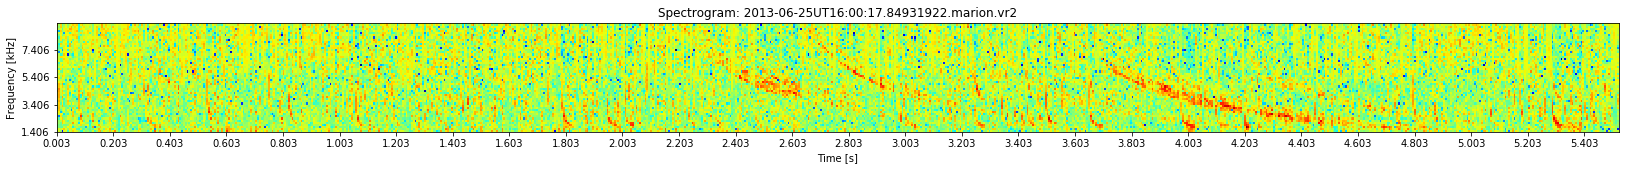

ca_cfar [15, 10, 0.001]


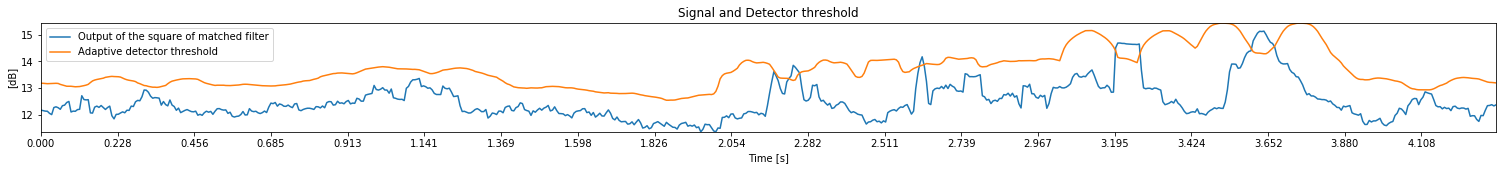

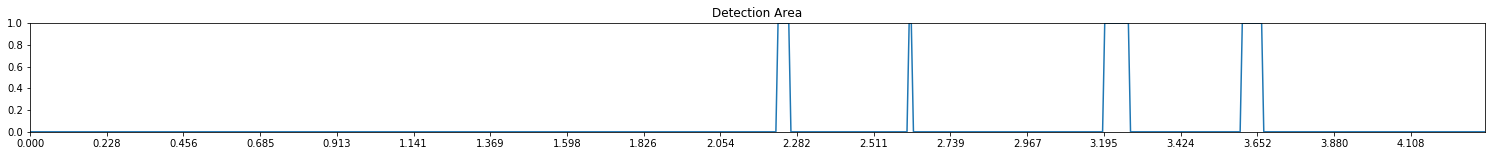

os_cfar [15, 10, 12, 0.001]


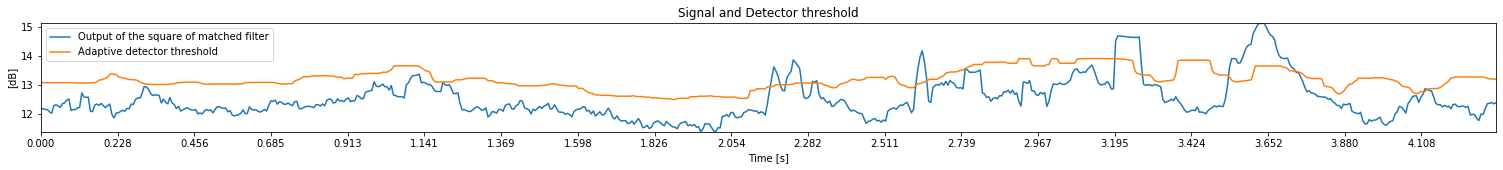

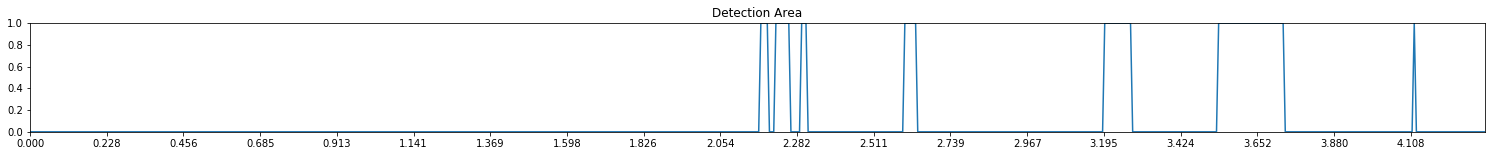

tm_cfar [15, 10, 0, 10, 0.001]


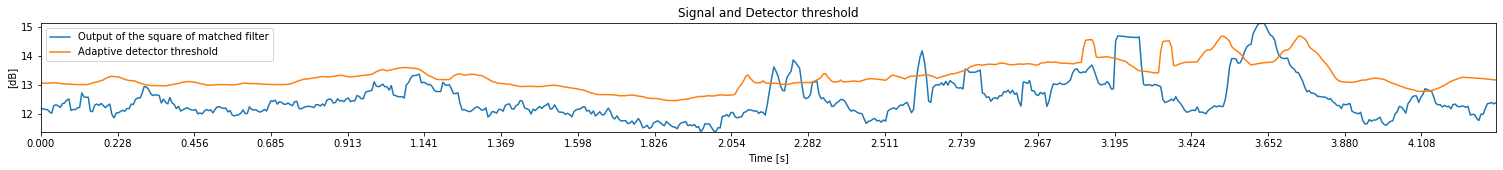

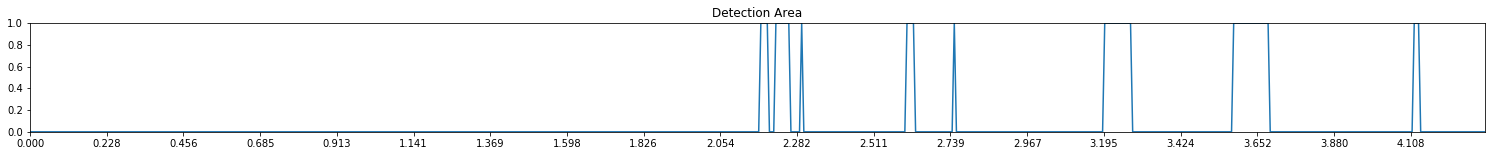

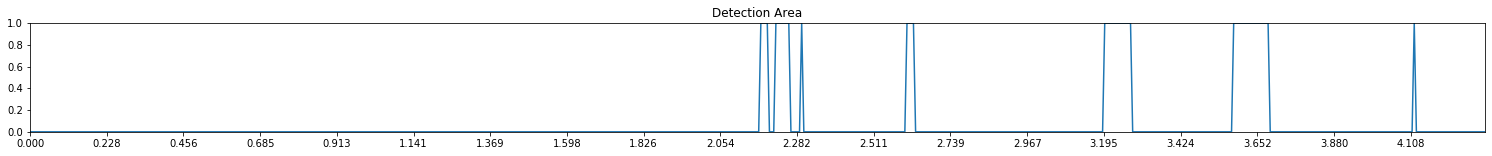

In [28]:
from sample import Sample
from dataset import Dataset
from database import Database
dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
site = 'marion'
my_dataset = Dataset(dataset_loc, site)
my_database = Database(dataset_loc, database_loc, site)
file = np.random.choice(my_database.get_test(),1)[0]
# file = '2013-04-22UT01:28:03.48279656.marion.vr2'
# file = '2013-06-04UT14:53:50.61780102.marion.vr2' # EXAMPLE FOR FUSION
# file = '2013-07-26UT01:33:36.10851914.marion.vr2'
# file = '2013-07-26UT03:50:39.03331914.marion.vr2'
# file = '2013-08-03UT23:17:33.39491914.marion.vr2'
# file = '2013-08-03UT19:24:29.49731914.marion.vr2'
# single whistler
# file = '2013-07-11UT04:40:57.58051937.marion.vr2'
# file = '2013-07-04UT18:59:25.44611930.marion.vr2'
# many well separated whistler
# file = '2013-07-26UT01:51:49.53571914.marion.vr2'
# file = '2013-06-26UT09:46:29.53571930.marion.vr2'
# two 0.2s close whistler
# file = '2013-06-09UT15:31:33.07447109.marion.vr2'
# single and two 0.4s close whistlers
# file = '2013-07-07UT05:16:32.05731922.marion.vr2'
# single with three 0.1s close whistlers
# file = '2013-07-03UT14:53:57.10051914.marion.vr2'
# thick whistler
# file = '2013-07-10UT19:34:12.46051938.marion.vr2'  # perfect
# file = '2013-08-03UT20:39:27.92931914.marion.vr2'
# file = '2013-10-20UT23:06:03.34899422.marion.vr2'
# complete rubish
# file = '2013-07-14UT17:33:58.63651930.marion.vr2'

sample = SampleDetector(dataset_loc, site, file)
print(file)

# kernel = sample.load_kernel('mean', [os.path.join(database_loc, site, 'kernels', 'kernel_data.h5')])
kernel = sample.load_kernel('sim', [0.45,80,3])
kernel -= kernel.mean()

transforms, transforms_params = ['slice','zscore'],[[1.5,9.5],[None]]
detector, detector_params = 'ca_cfar', [15,10,1e-3]
size = (4*sample.get_time_freq_ratio(dec=0), 2)
sample.apply_transform(transforms, transforms_params)
sample.spectrogram_plot(figsize=size, xlabel='Time [s]', ylabel='Frequency [kHz]',zlabel='sprectrum magnitude [dB]', 
                           xaxis=True, yaxis=True,ticks=[0.2,2],title="Spectrogram: "+sample.get_file(), cmap='jet', cmap_show=False)
# sample.plot_corr_output(transforms, transforms_params, detector, detector_params, kernel=kernel)

N, G, pfa = 15,10,1e-3
k, T1,T2 = 12, 0, 10
for detector, detector_params in zip(['ca_cfar','os_cfar','tm_cfar'],[[N,G,pfa],[N,G,k,pfa],[N,G,T1,T2,pfa]]):
    print(detector, detector_params)
    sample.plot_corr_output(transforms, transforms_params, detector, detector_params, kernel=kernel)
    sample.plot_detection_area(transforms, transforms_params, detector, detector_params, kernel=kernel)

sample.plot_linear_fusion_cfar(transforms, transforms_params, kernel,
                                  [N,G,pfa],[N,G,k,pfa],[N,G,T1,T2,pfa])

2013-07-11UT05:39:45.20931938.marion.vr2


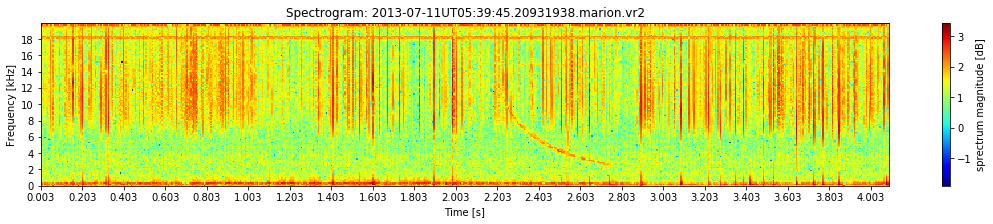

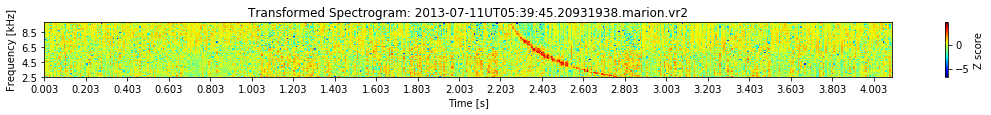

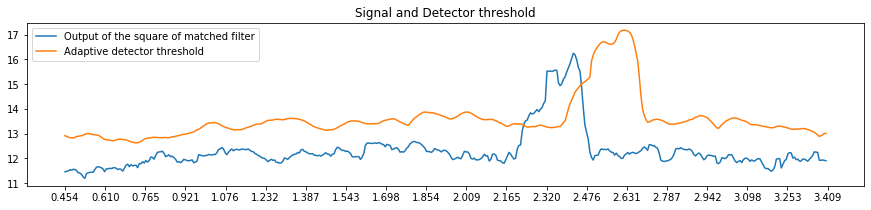

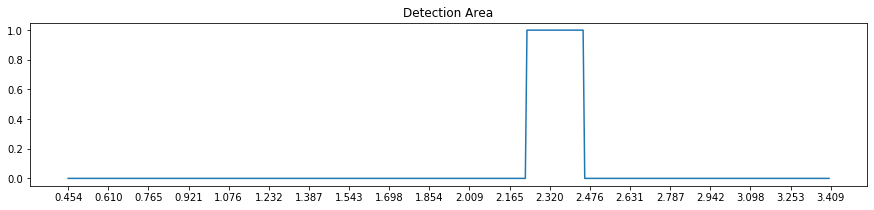

['2013-07-11UT05:39:45.20931938.marion.vr2'
 array([[array([  2.42868, 313.     ]), 0]], dtype=object)
 array([0, 1, 0])]


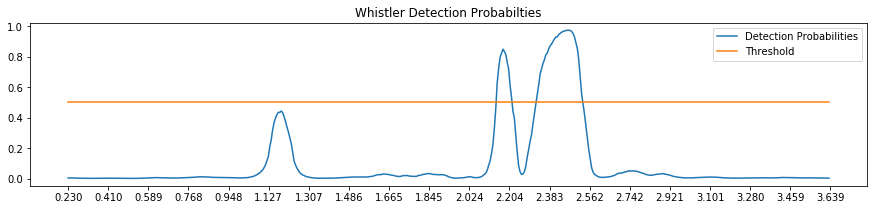

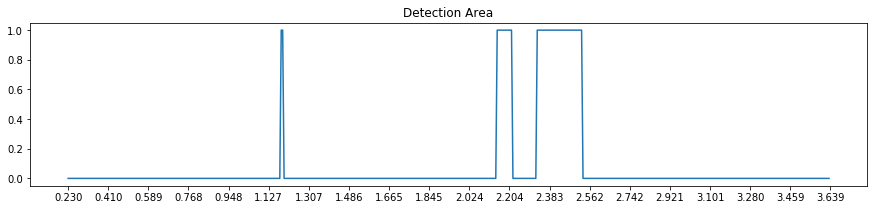

['2013-07-11UT05:39:45.20931938.marion.vr2'
 array([[array([  2.42868, 313.     ]), 0],
       [array([1.183075  , 0.44316116]), 1],
       [array([2.1743    , 0.84951955]), 1]], dtype=object)
 array([0, 1, 2])]


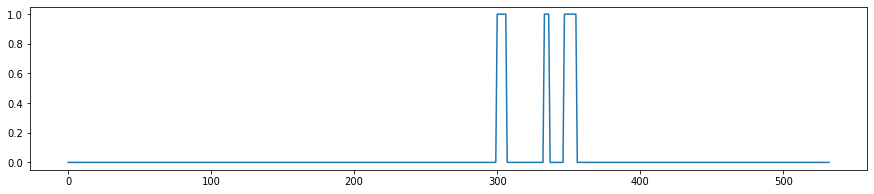

array(['2013-07-11UT05:39:45.20931938.marion.vr2',
       array([[array([  2.42868, 313.     ]), 0],
       [array([2.16151  , 0.7946705]), 1],
       [array([2.46847   , 0.97439414]), 1]], dtype=object),
       array([0, 1, 2])], dtype=object)

In [2]:
# from sample import Sample
# from dataset import Dataset
# from database import Database
# dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
# database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
# site = 'marion'
# my_dataset = Dataset(dataset_loc, site)
# my_database = Database(dataset_loc, database_loc, site)
# file = np.random.choice(my_database.get_test(),1)[0]
# # 
# # file = '2013-07-25UT04:30:47.73731922.marion.vr2' #1
# # file= '2013-06-25UT14:04:42.60451922.marion.vr2' #2 # USE THIS FOR POSTER
# # file = '2013-01-27UT00:58:07.81987602.marion.vr2'   # use this in research
# # file = '2013-07-02UT14:23:00.07651914.marion.vr2'
# # file = '2013-07-02UT15:03:58.44451914.marion.vr2'
# # file = '2013-07-07UT14:34:37.06211914.marion.vr2'
# # file = '2013-06-09UT12:52:37.22969609.marion.vr2' #4 # use THIS instead
# # file = '2013-05-18UT13:22:09.68232156.marion.vr2'
# # file = '2013-05-20UT16:18:21.03742156.marion.vr2'  # ML detects more
# # file = '2013-05-20UT16:18:21.03742156.marion.vr2'
# # file = '2013-05-18UT13:49:22.14312156.marion.vr2'
# my_sample = SampleDetector(dataset_loc, site,file)

# my_sample.spectrogram_with_axis(log10=True)
# print(my_sample.get_file())
# time_err=0.1
# diff_err=0.1
# freq_size = 3
# freq_slice = [2.5,10]
# detector, detector_params = 'tm_cfar', [10,25,1e-6,10]
# transforms, transforms_params = ['slice','zscore'],[freq_slice,[None]]
# size = (freq_size*my_sample.get_time_freq_ratio(dec=0), freq_size)

# # time and time-frequency
# # my_sample.signal_plot(sig=None, EW=True, figsize=size, title="ADC signal: "+my_sample.get_file())
# my_sample.spectrogram_plot(figsize=(size[0]+4,size[1]), xlabel='Time [s]', ylabel='Frequency [kHz]',zlabel='sprectrum magnitude [dB]', 
#                            xaxis=True, yaxis=True, ticks=[0.2,2],
#                            title="Spectrogram: "+my_sample.get_file(), cmap='jet', cmap_show=True)
# # transformation
# # r1, l1 = my_sample.spectrogram_time_cut_plot([2.5,2], figsize=size, title='Whstler and Spheric levels before pre-processing', 
# #                                     legend=['Whistler', 'Spheric'], stats=True, legend_loc='upper right')
# # my_sample.apply_transform(['zscore'], [[None]])
# # r2, l2 = my_sample.spectrogram_time_cut_plot([2.5,2], figsize=size, title='Whstler and Spheric levels after pre-processing', 
# #                                     legend=['Whistler', 'Spheric'], stats=True, legend_loc='upper right')

# # my_sample.spectrogram_with_axis()
# # my_sample.apply_transform(['slice'], [[2.5,10]])
# # my_sample.spectrogram_plot(figsize=(size[0]+4,size[1]-2), xlabel='Time [s]', ylabel='Frequency [kHz]',zlabel='spectrum magnitude dB', 
# #                            xaxis=True, yaxis=True, ticks=[0.2,2],
# #                            title="Transformed Spectrogram: "+my_sample.get_file(), cmap='jet', cmap_show=True)
# my_sample.spectrogram_with_axis()
# my_sample.apply_transform(transforms, transforms_params)
# my_sample.spectrogram_plot(figsize=(size[0]+4,size[1]-2), xlabel='Time [s]', ylabel='Frequency [kHz]',zlabel='Z score', 
#                            xaxis=True, yaxis=True, ticks=[0.2,2],
#                            title="Transformed Spectrogram: "+my_sample.get_file(), cmap='jet', cmap_show=True)


# # matched filter
# my_sample.spectrogram_with_axis()
# kernel = my_sample.whistler_sim(decay=3, whistler_time=0.7, whistler_freq_len=7.5, whistler_freq_start=2.5, 
#                                 thickness=1,size=50,freq_slice=freq_slice)
# # fig=plt.figure(figsize=(3,1));
# # img=plt.pcolormesh(np.linspace(0,0.7,kernel.shape[1]),np.linspace(2.5,10,kernel.shape[0]),kernel, cmap='jet');
# # fig.colorbar(mappable=img, label='Kernel')
# # plt.title("Whistler Simulation");plt.xlabel('Time [s]');plt.xlabel('Frequency [kHz]');plt.show();
# my_sample.plot_corr_output(transforms, transforms_params, detector, detector_params, diff_err, time_err, kernel)
# my_sample.plot_detection_area(transforms, transforms_params, detector, detector_params, diff_err, time_err, kernel)
# evaluation = my_sample.evaluate_detector(transforms, transforms_params,detector, detector_params, diff_err=diff_err, time_err=time_err, kernel=kernel)
# print(evaluation)

# # machine learning
# aug=True
# transforms, transforms_params = ['zscore'],[[None]]
# params = str(transforms)+'_'+str(transforms_params)
# params +='_aug' if aug else ''
# scaler_path = os.path.join(database_loc,site,'models',params+'_scaler.pickle')
# model_path = os.path.join(database_loc,site,'models',params+'_model.h5')
# input_shape = [48,108]

# scaler = pickle.load( open( scaler_path, "rb" ) )['scaler']
# model = load_model(model_path)

# transforms, transforms_params = ['slice','zscore'],[[2.5,10],[None]]
# my_sample.plot_prob_output_ml(transforms, transforms_params ,input_shape, scaler, model)                   
# my_sample.plot_detection_area_ml(transforms, transforms_params ,input_shape, scaler, model)
# evaluation = my_sample.evaluate_detector_ml(transforms, transforms_params ,input_shape, scaler, model, diff_err, time_err)
# print(evaluation)

# f,prob,shift = my_sample.prob_output_ml(transforms, transforms_params, input_shape, scaler, model)
# plt.figure(figsize=size)
# plt.plot(my_sample.prob_area_ml(prob[:,1], window = 10, threshold = 0.6, e=-0.05))
# plt.show()
# my_sample.evaluate_detector_ml_cnn_ouput(prob=prob, shift=shift ,diff_err=diff_err, time_err=time_err, window=10,threshold=0.6, e=-0.05)

In [10]:
# fn
# '2013-07-31UT01:46:16.53091914.marion.vr2'

# fp
# '2013-05-28UT14:13:02.78732164.marion.vr2'
# '2013-06-10UT14:34:37.14169609.marion.vr2'
# '2013-06-26UT10:54:31.14851930.marion.vr2'

2013-05-20UT16:18:21.03742156.marion.vr2


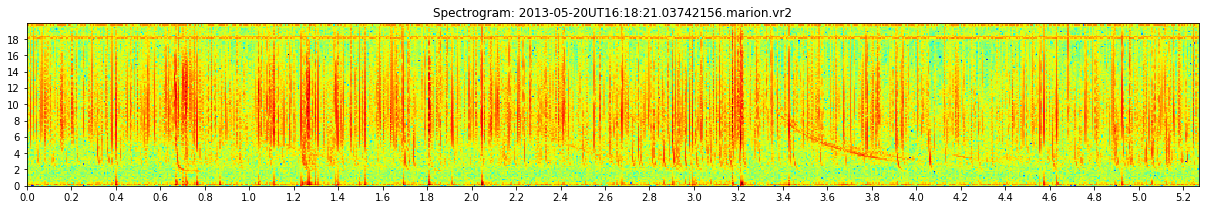

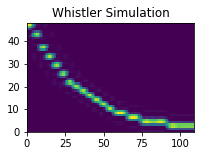

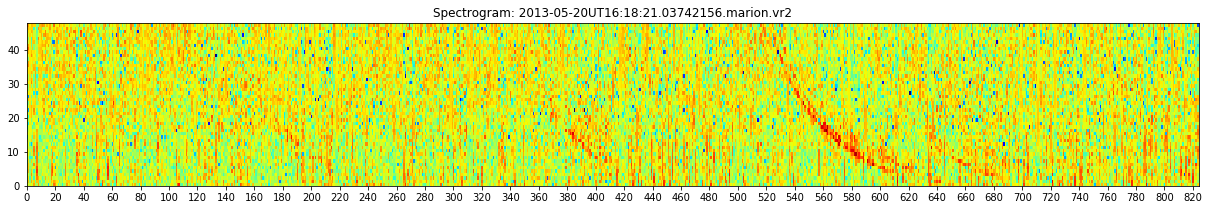

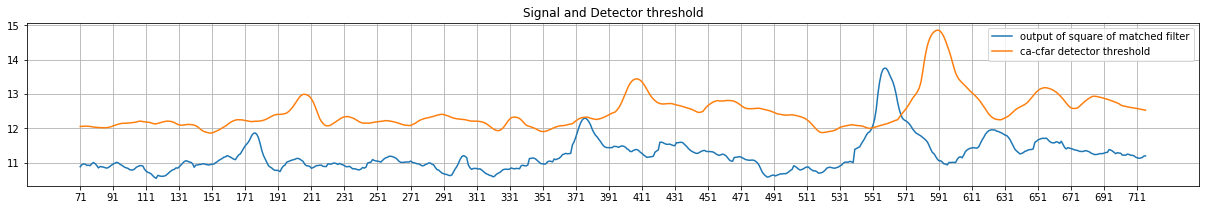

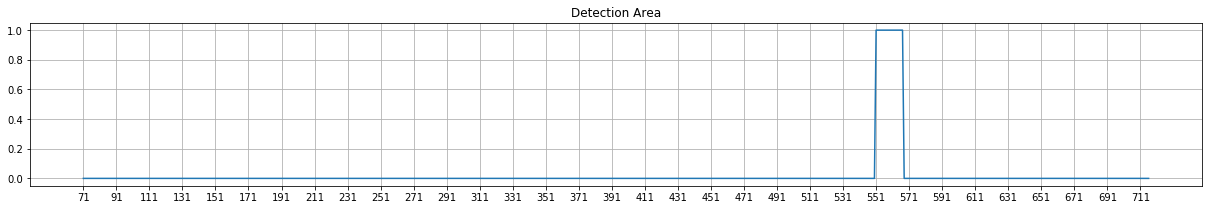

['2013-05-20UT16:18:21.03742156.marion.vr2'
 array([[array([ 3.56903301, 10.96894048]), 0]], dtype=object)
 array([0, 1, 0])]


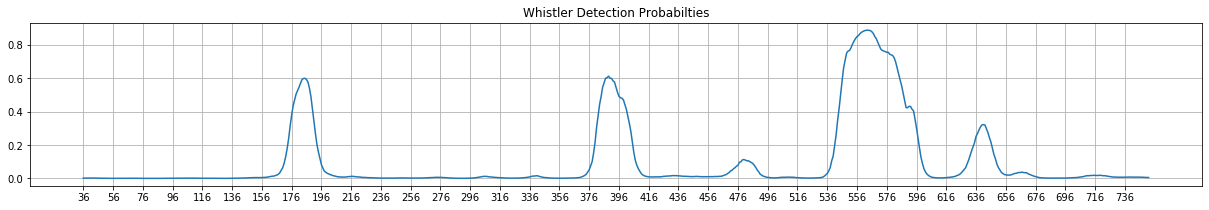

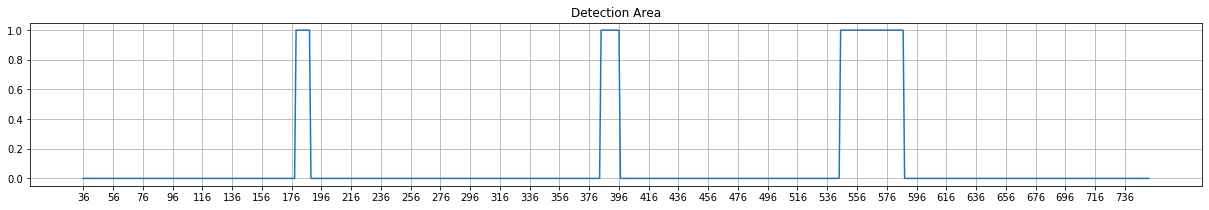

['2013-05-20UT16:18:21.03742156.marion.vr2'
 array([[array([3.61380583, 0.05830028]), 0],
       [array([1.17048932, 0.01069977]), 1],
       [array([2.48808932, 0.01083078]), 1]], dtype=object)
 array([0, 1, 2])]


In [12]:
# import sys
# import os
# import numpy as np
# import pandas as pd
# import datetime
# import tqdm
# from collections import deque
# from math import ceil, sqrt, floor, gamma
# from scipy import signal, stats, fftpack 
# from sklearn import preprocessing
# from PIL import Image
# import multiprocessing as mp
# import matplotlib.pyplot as plt
# # import python library
# sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))

# from sample import Sample
# from dataset import Dataset
# from database import Database
# dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
# database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
# site = 'marion'
# my_dataset = Dataset(dataset_loc, site)
# my_database = Database(dataset_loc, database_loc, site)
# file = np.random.choice(my_database.get_test(),1)[0]

# # file = '2013-07-25UT04:30:47.73731922.marion.vr2'
# # file= '2013-06-25UT14:04:42.60451922.marion.vr2' # USE THIS FOR POSTER
# # file = '2013-01-27UT00:58:07.81987602.marion.vr2'   # use this in research
# # file = '2013-07-02UT14:23:00.07651914.marion.vr2'
# # file = '2013-07-02UT15:03:58.44451914.marion.vr2'
# # file = '2013-07-07UT14:34:37.06211914.marion.vr2'
# # file = '2013-06-09UT12:52:37.22969609.marion.vr2' # use THIS instead
# # file = '2013-05-18UT13:22:09.68232156.marion.vr2'
# # file = '2013-05-20UT16:18:21.03742156.marion.vr2'  # ML detects more
# my_sample = SampleDetector(dataset_loc, site,file)

# my_sample.spectrogram_with_axis(log10=True)
# print(my_sample.get_file())
# time_err=0.2
# diff_err=0.3
# freq_size = 3
# freq_slice = [2.5,10]
# detector, detector_params = 'tm_cfar', [10,25,1e-6,10]
# transforms, transforms_params = ['slice','zscore'],[freq_slice,[None]]
# size = (freq_size*my_sample.get_time_freq_ratio(dec=0), freq_size)

# my_sample.spectrogram_plot(figsize=size, zlabel='sprectrum magnitude [dB]', xaxis=True, yaxis=True, ticks=[0.2,2],
#                            title="Spectrogram: "+my_sample.get_file(), cmap='jet', cmap_show=False)
# kernel = my_sample.whistler_sim(decay=3, whistler_time=0.7, whistler_freq_len=7.5, whistler_freq_start=2.5, 
#                                 thickness=1,size=25,freq_slice=freq_slice)
# fig=plt.figure(figsize=(3,int(size[0]*kernel.shape[1]/my_sample.get_spectrogram().shape[1])));img=plt.pcolormesh(kernel);plt.title("Whistler Simulation");plt.show();

# my_sample.apply_transform(transforms, transforms_params)
# my_sample.spectrogram_plot(figsize=size, zlabel='sprectrum magnitude [dB]', xaxis=False, yaxis=False, ticks=[20,10],
#                            title="Spectrogram: "+my_sample.get_file(), cmap='jet', cmap_show=False)

# my_sample.plot_corr_output(transforms, transforms_params, detector, detector_params, diff_err, time_err, kernel)
# my_sample.plot_detection_area(transforms, transforms_params, detector, detector_params, diff_err, time_err, kernel)
# print(my_sample.evaluate_detector(transforms, transforms_params,detector, detector_params, diff_err=diff_err, time_err=time_err, kernel=kernel))

# ############ ML
# aug=True
# transforms, transforms_params = ['zscore'],[[None]]
# params = str(transforms)+'_'+str(transforms_params)
# params +='_aug' if aug else ''
# scaler_path = os.path.join(database_loc,site,'models',params+'_scaler.pickle')
# model_path = os.path.join(database_loc,site,'models',params+'_model.h5')
# input_shape = [48,108]

# scaler = pickle.load( open( scaler_path, "rb" ) )['scaler']
# model = load_model(model_path)

# transforms, transforms_params = ['slice','zscore'],[[2.5,10],[None]]
# my_sample.plot_prob_output_ml(transforms, transforms_params ,input_shape, scaler, model)                   
# my_sample.plot_detection_area_ml(transforms, transforms_params ,input_shape, scaler, model)
# print(my_sample.evaluate_detector_ml(transforms, transforms_params ,input_shape, scaler, model, diff_err=0.3, time_err=0.2))

2013-06-09UT12:52:37.22969609.marion.vr2


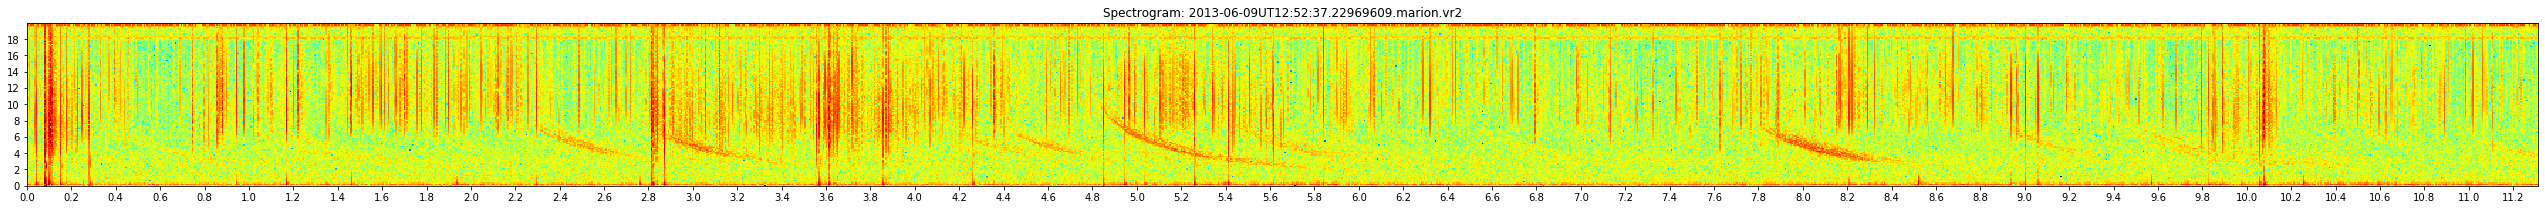

/home/othniel/wdml/data/databases/awdEvents1/marion/models/['zscore']_[[None]]_aug_scaler.pickle


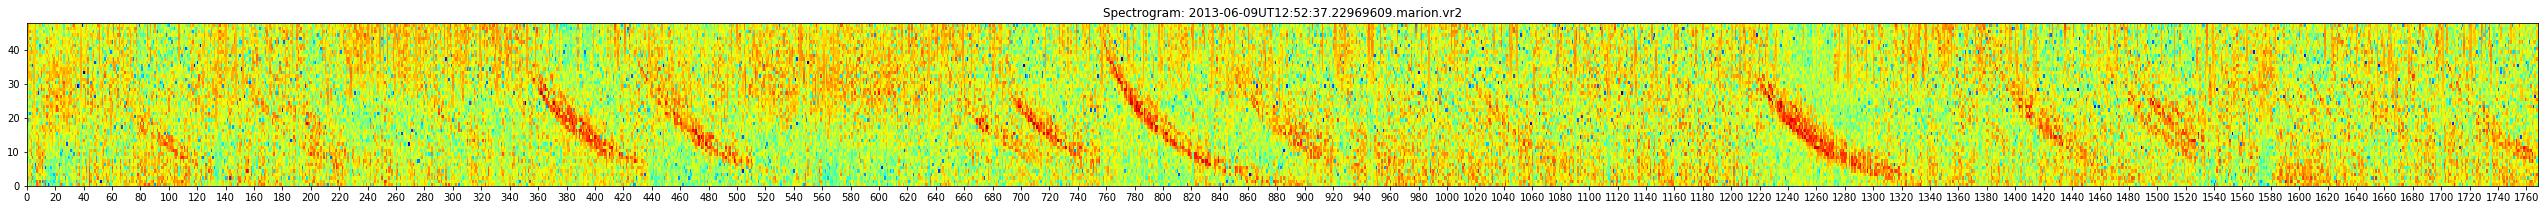

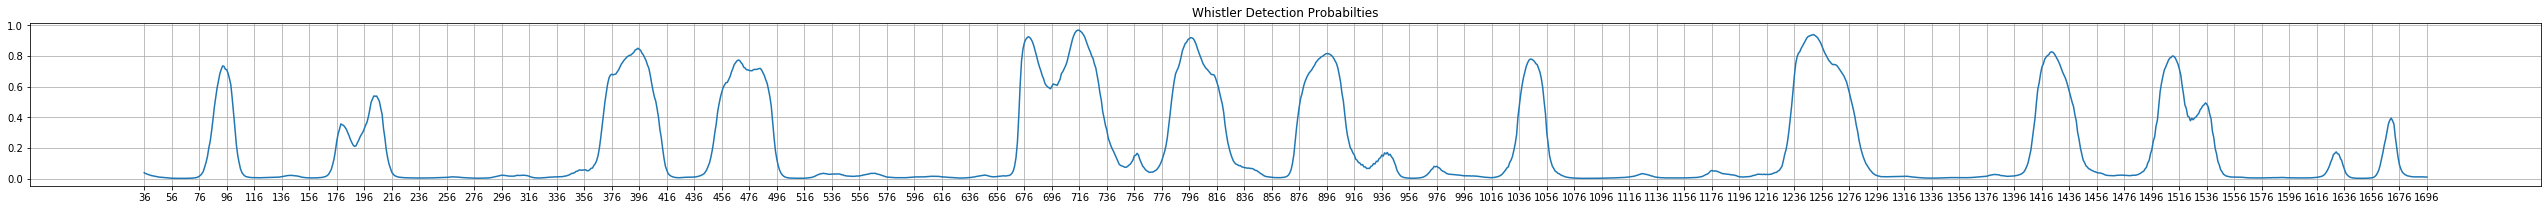

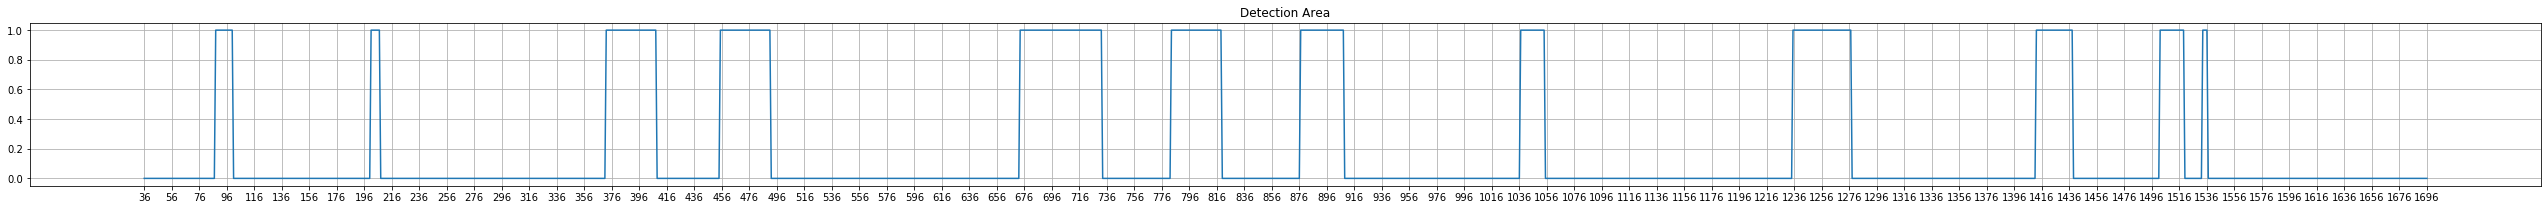

['2013-06-09UT12:52:37.22969609.marion.vr2'
 array([[array([2.48889593, 0.00329219]), 0],
       [array([3.0199457 , 0.00389346]), 0],
       [array([4.49152941, 0.00515775]), 0],
       [array([5.11855204, 0.00663081]), 0],
       [array([5.70718552, 0.03191437]), 0],
       [array([8.02972851, 0.05706795]), 0],
       [array([9.11102262, 0.07204551]), 0],
       [array([9.81482353, 0.23946051]), 0],
       [array([0.59503167, 0.00133276]), 1],
       [array([1.29883258, 0.00209435]), 1],
       [array([6.6861086 , 0.05581432]), 1]], dtype=object)
 array([0, 8, 3])]


In [21]:
# from sample import Sample
# from dataset import Dataset
# from database import Database
# dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
# database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
# site = 'marion'
# my_dataset = Dataset(dataset_loc, site)
# my_database = Database(dataset_loc, database_loc, site)
# file = np.random.choice(my_database.get_train(),1)[0]

# file = '2013-07-25UT04:30:47.73731922.marion.vr2'
# file= '2013-06-25UT14:04:42.60451922.marion.vr2' # USE THIS FOR POSTER
# # file = '2013-01-27UT00:58:07.81987602.marion.vr2'   # use this in research
# # file = '2013-07-02UT14:23:00.07651914.marion.vr2'
# # file = '2013-07-02UT15:03:58.44451914.marion.vr2'
# # file = '2013-07-07UT14:34:37.06211914.marion.vr2'
# file = '2013-06-09UT12:52:37.22969609.marion.vr2'
# # file = '2013-05-18UT13:22:09.68232156.marion.vr2'
# my_sample = SampleDetector(dataset_loc, site,file)
# print(file)
# size = (freq_size*my_sample.get_time_freq_ratio(dec=0), freq_size)
# my_sample.spectrogram_plot(figsize=size, zlabel='sprectrum magnitude [dB]', xaxis=True, yaxis=True, ticks=[0.2,2],
#                            title="Spectrogram: "+my_sample.get_file(), cmap='jet', cmap_show=False)

# time_err=0.2
# diff_err=0.3

# aug=True
# transforms, transforms_params = ['zscore'],[[None]]
# params = str(transforms)+'_'+str(transforms_params)
# params +='_aug' if aug else ''
# scaler_path = os.path.join(database_loc,site,'models',params+'_scaler.pickle')
# model_path = os.path.join(database_loc,site,'models',params+'_model.h5')
# input_shape = [48,108]

# scaler = pickle.load( open( scaler_path, "rb" ) )['scaler']
# model = load_model(model_path)
# print(scaler_path)

# transforms, transforms_params = ['slice','zscore'],[[2.5,10],[None]]
# my_sample.apply_transform(transforms, transforms_params)
# my_sample.spectrogram_plot(figsize=size, zlabel='sprectrum magnitude [dB]', xaxis=False, yaxis=False, ticks=[20,10],
#                            title="Spectrogram: "+my_sample.get_file(), cmap='jet', cmap_show=False)

# my_sample.plot_prob_output_ml(transforms, transforms_params ,input_shape, scaler, model)                   
# my_sample.plot_detection_area_ml(transforms, transforms_params ,input_shape, scaler, model)
# print(my_sample.evaluate_detector_ml(transforms, transforms_params ,input_shape, scaler, model, diff_err=0.3, time_err=0.2))

In [73]:
# errors in detection
# 2013-07-02UT15:03:58.44451914.marion.vr2
# 2013-07-02UT16:30:40.82531914.marion.vr2
# 2013-05-20UT15:19:54.09342156.marion.vr2
# 2013-07-03UT15:11:30.48931914.marion.vr2
# 2013-07-19UT01:16:49.26051914.marion.vr2
# 2013-07-25UT15:06:06.85411922.marion.vr2
# 2013-08-04UT00:13:33.08771922.marion.vr2
# 2013-05-18UT13:21:49.81672156.marion.vr2
# 2013-07-04UT15:44:24.35171922.marion.vr2
# 2013-05-28UT13:48:16.34892156.marion.vr2
# 2013-07-07UT13:12:42.47651914.marion.vr2


# samples = ['2013-09-02UT16:17:50.19059414.marion.vr2','2013-07-07UT05:19:49.99651922.marion.vr2','2013-06-28UT04:03:12.85091922.marion.vr2',
#             '2013-10-08UT01:58:59.23379430.marion.vr2','2013-11-09UT22:50:37.90899422.marion.vr2','2013-07-11UT04:36:24.27491938.marion.vr2',
#             '2013-07-25UT04:30:47.73731922.marion.vr2','2013-08-04UT21:34:56.49251922.marion.vr2','2013-02-24UT15:04:07.65347602.marion.vr2',
#             '2013-07-02UT16:10:39.77571914.marion.vr2']
# samples_whistlers_coor = [[[2.2,2.9],[2.9,3.6]],[[2.2,2.9],[5.3,6],[5.8,6.4]],[[2.5,3.2],[4.9,5.5],[6.5,7.2]],
#                           [[2.3,2.6]],[[2.3,2.6],[2.6,3.5]],[[1.2,1.6],[2.3,2.6]],
#                           [[1.8,2.4],[2.4,3.3]],[[2,3]],[[2.3,2.6]],
#                           [[2,3.2],[3.4,3.6],[5.5,6]]]
# samples_whistlers_coor_loc = [[[345,365],[425,455]],[[345,365],[765,855],[865,885]],[[325,395],[725,795],[985,1045]],
#                               [[335,405]],[[45,85],[335,355],[405,445]],[[175,195],[345,355]],
#                               [[265,295],[315,385]],[[325,355]],[[325,375]],
#                               [[285,365],[495,515],[805,855]]]
# samples_whistlers_coor_loc_ = [[[280,520]],[[300,440],[700,960]],[[240,460],[640,880],[940,1100]],
#                               [[260,460]],[[0,140],[240,500]],[[120,240],[280,420]],
#                               [[200,420]],[[180,460]],[[240,420]],
#                               [[220,440],[780,900]]]

# my_sample = Detector(dataset_loc, site, np.random.choice(samples,1)[0])
# my_sample = Detector(dataset_loc, site, samples[8])